In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sc.settings.n_jobs = 8
sc.set_figure_params(dpi=100, dpi_save=600, frameon=False, figsize=(5,5))
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Arial"
%config InlineBackend.figure_format = 'retina'

In [2]:
adata = sc.read_h5ad('/Users/pax/Library/CloudStorage/OneDrive-KarolinskaInstitutet/iPain_cellxgene/Nociceptors_RNA.h5ad.gz')
del adata.raw
adata.var_names = adata.var.gene_name.to_list()
adata.obs.Time = adata.obs.Time.cat.reorder_categories(['0day','0.25day','0.5day','1day','1.5day','2day','3day','7day','14day','28day'])
adata.obs.Pain_dynamics = adata.obs.Pain_dynamics.cat.reorder_categories(['Reference','Moving','Pain','Recovery','Stuck']).cat.rename_categories({'Stuck':'Lasting'})
adata.var_names_make_unique()

/Users/pax/miniconda3/envs/rnase4/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/pax/miniconda3/envs/rnase4/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/pax/miniconda3/envs/rnase4/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [3]:
adata.layers['scVI_gene'] = adata.X.copy()
adata.X = adata.layers['counts'].copy()
adata_noci = adata[adata.obs.Conditions.isin(['Naive', 'Crush'])].copy()

In [10]:
for ad in [adata, adata_noci]:
    sc.pp.normalize_total(ad)
    sc.pp.log1p(ad)
    ad.layers['log_norm'] = ad.X.copy()

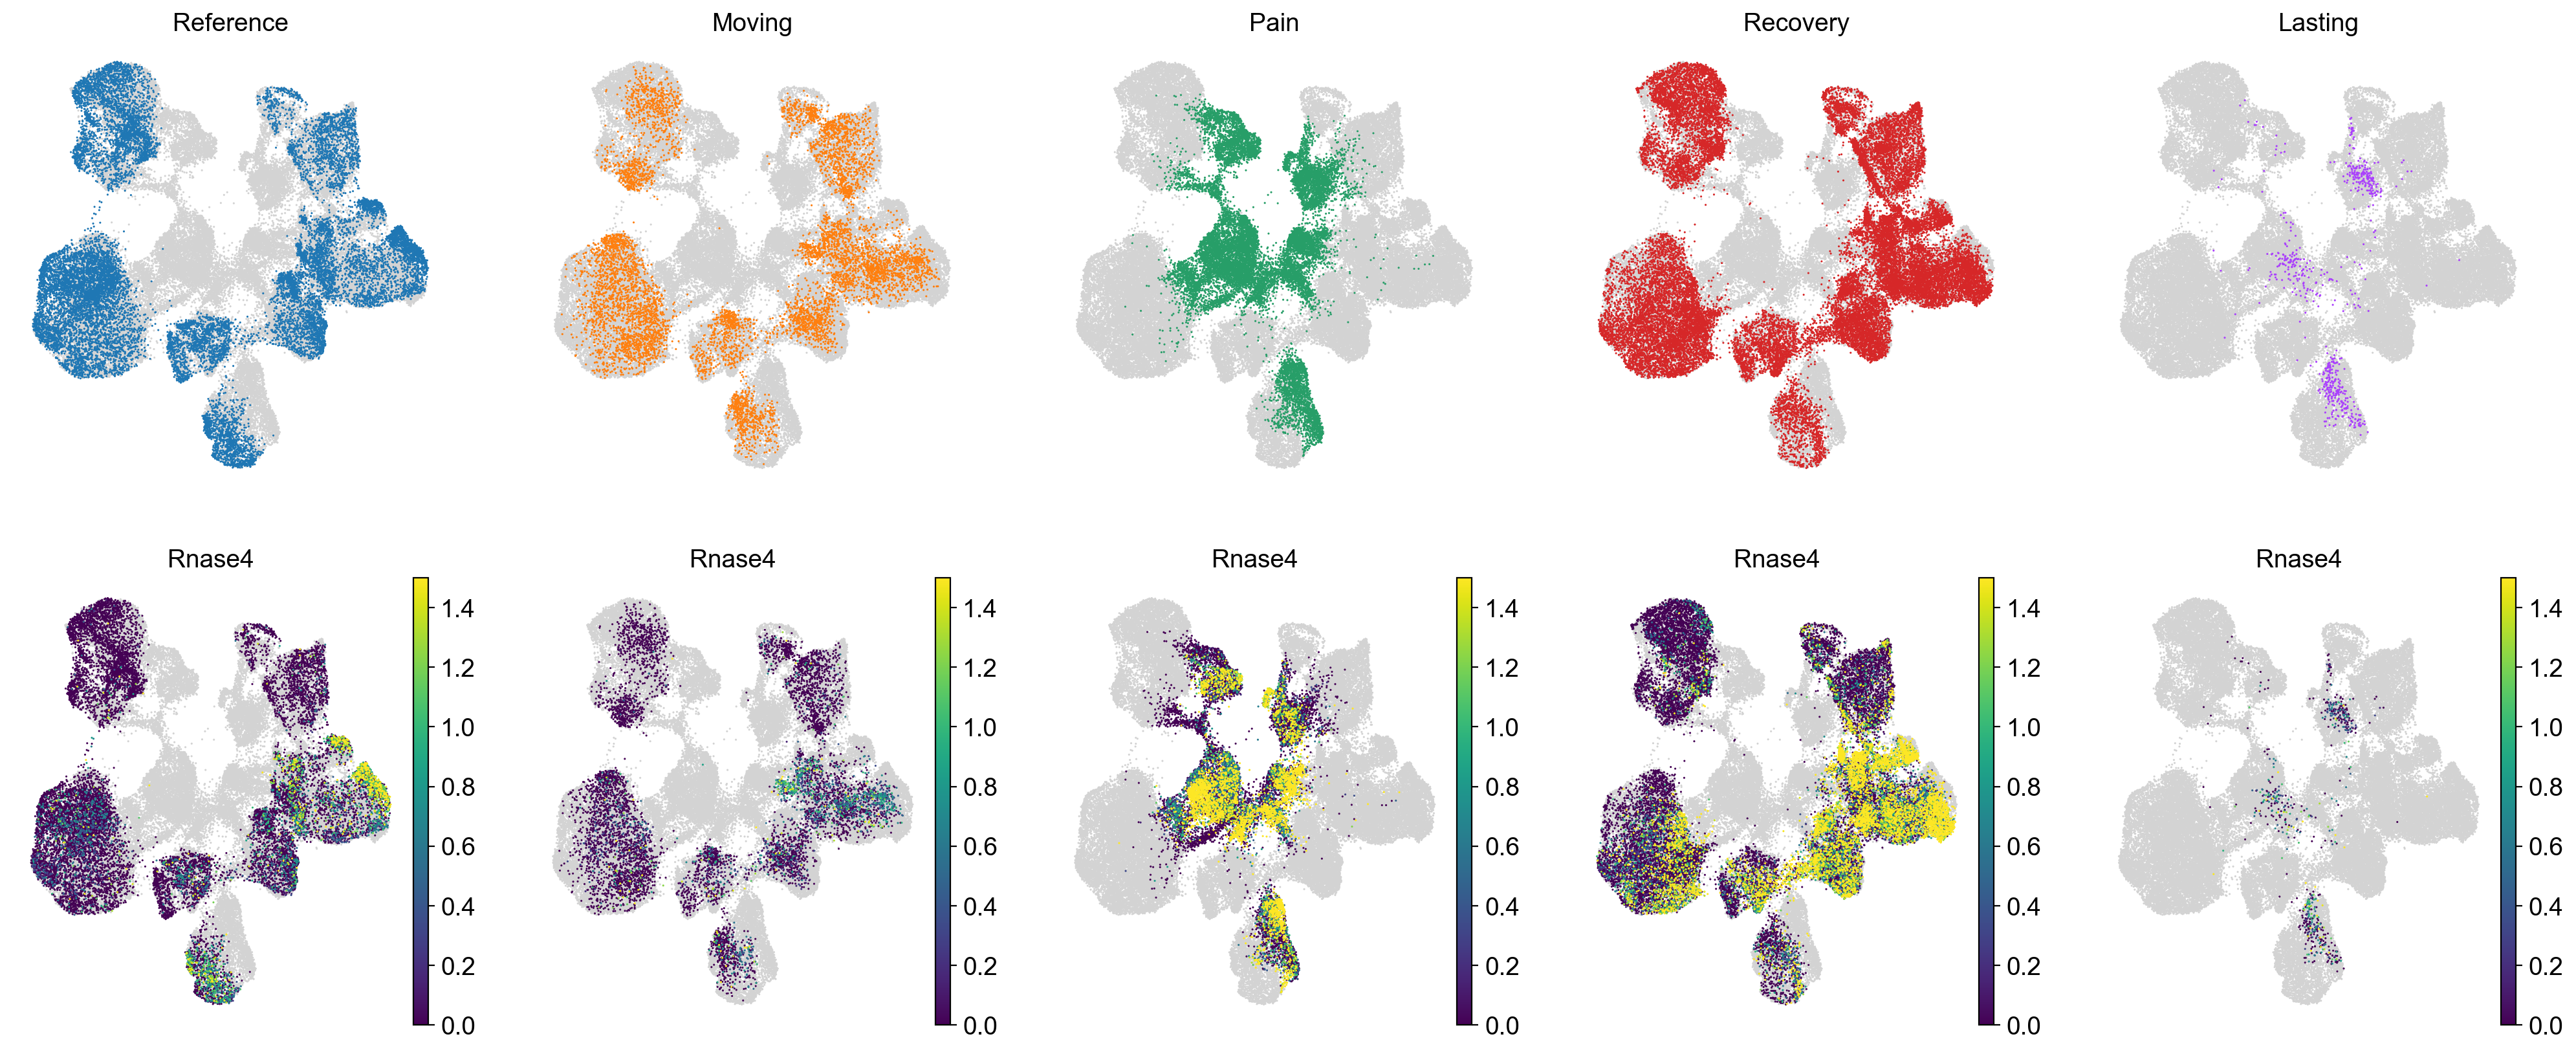

In [18]:
fig, ax = plt.subplots(2, 5, figsize=(25, 10))
ax = ax.ravel()
for i, d in enumerate(adata.obs.Pain_dynamics.cat.categories):
    sc.pl.umap(adata[adata.obs.Pain_dynamics != d], ax=ax[i], show=False, s=5)
    sc.pl.umap(adata[adata.obs.Pain_dynamics == d], color='Pain_dynamics', ax=ax[i], show=False, s=5, legend_loc=None)
    
    sc.pl.umap(adata[adata.obs.Pain_dynamics != d], ax=ax[i+5], show=False, s=5)
    sc.pl.umap(adata[adata.obs.Pain_dynamics == d], color='Rnase4', ax=ax[i+5], vmin=0, vmax=1.5, show=False, s=5)
    ax[i].set_title(d)
fig.savefig('figures/umap_noci_Rnase4_dynamics_multi.pdf', bbox_inches='tight', dpi=600)

In [42]:
def cal_sem(x):
    sem = stats.sem(x)
    return x.mean() - sem, x.mean() + sem

In [40]:
df_plot = sc.get.obs_df(adata_noci,
                        keys=['Rnase4','Time','CellTypes_scANVI_pred','Trp53'],
                        layer='log_norm')

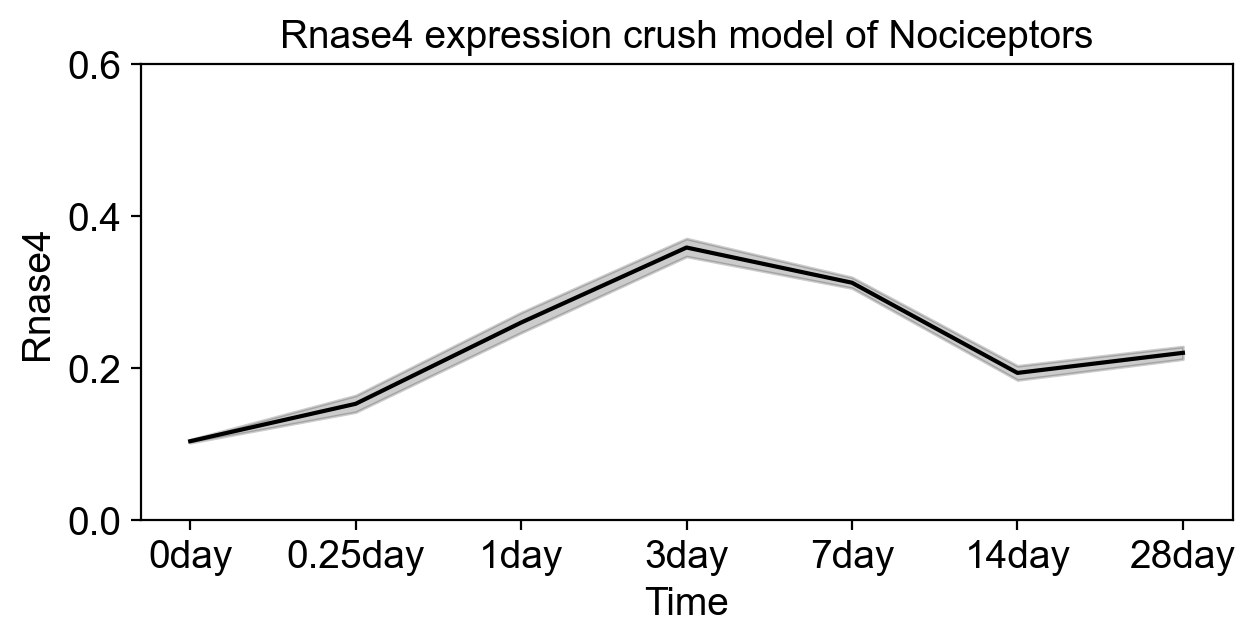

In [17]:
fig, ax = plt.subplots(figsize=(7,3))
sns.lineplot(data=df_plot, x='Time', y='Rnase4', errorbar=cal_sem, ax=ax, color='k')
ax.grid(False)
ax.set_title('Rnase4 expression crush model of Nociceptors')
ax.set_ylim(0, 0.6)
fig.savefig('./figures/Rnase4_exp_crush_noci.pdf', bbox_inches='tight', dpi=300)

In [7]:
sk_color = {
 'NF1': '#ffd900',
 'NF2': '#ff8c00',
 'NF3': '#ff4040',
 'NP': '#67cd00',
 'PEP1': '#87cefa',
 'PEP2': '#1c86ee',
 'SST': '#104e8b',
 'cLTMR1': '#98f5ff',
 'p_cLTMR2': '#00ced1',
 'NFs': '#104e8b',
 'Nociceptors': '#ff8c00'
 }

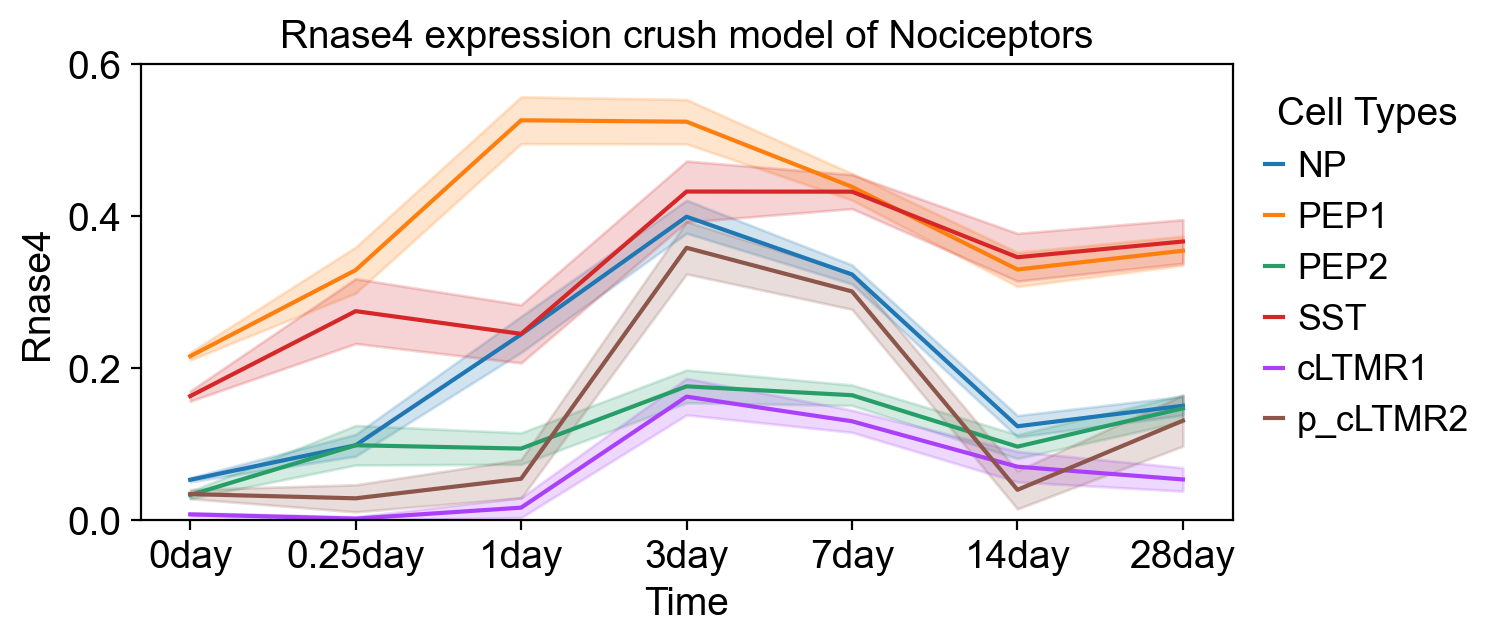

In [19]:
fig, ax = plt.subplots(figsize=(7,3))
sns.lineplot(data=df_plot, x='Time', y='Rnase4', hue='CellTypes_scANVI_pred', errorbar=cal_sem, ax=ax)
ax.grid(False)
ax.set_title('Rnase4 expression crush model of Nociceptors')
ax.set_ylim(0, 0.6)
ax.legend_.set_bbox_to_anchor((1, 1))
ax.legend_.set_title('Cell Types')
ax.legend_.set_frame_on(False)
fig.savefig('./figures/Rnase4_exp_crush_noci_subtypes.pdf', bbox_inches='tight', dpi=300)

In [ ]:
adata_noci.write_h5ad('./Results/05_noci.h5ad', compression='gzip')